[View in Colaboratory](https://colab.research.google.com/github/hhngan/MLFollow/blob/master/02_Loan_Prediction.ipynb)

In [0]:
# GIT file: https://github.com/hhngan/MLFollow/blob/master/data/LoanProblem_Train.csv
# RAW file: https://raw.githubusercontent.com/hhngan/MLFollow/master/data/LoanProblem_Train.csv

PATHS = "https://raw.githubusercontent.com/hhngan/MLFollow/master/data/LoanProblem_Train.csv"

import pandas as pd
import numpy as np
import matplotlib as plt

df = pd.read_csv(PATHS) #Reading the dataset in a dataframe using Pandas

In [0]:
df.head()

In [0]:
df.describe()

In [0]:
df['Property_Area'].value_counts()

In [0]:
df['ApplicantIncome'].hist(bins=50)

In [0]:
df.boxplot(column='ApplicantIncome')

In [0]:
df.boxplot(column='ApplicantIncome', by = 'Education')

In [0]:
df.boxplot(column='LoanAmount')

In [0]:
temp1 = df['Credit_History'].value_counts(ascending=True)
temp2 = df.pivot_table(values='Loan_Status',index=['Credit_History'],aggfunc=lambda x: x.map({'Y':1,'N':0}).mean())
print('Frequency Table for Credit History:')
print(temp1)

print('\nProbility of getting loan for each Credit History class:')
print(temp2)

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Credit_History')
ax1.set_ylabel('Count of Applicants')
ax1.set_title("Applicants by Credit_History")
temp1.plot(kind='bar')

ax2 = fig.add_subplot(122)
temp2.plot(kind = 'bar')
ax2.set_xlabel('Credit_History')
ax2.set_ylabel('Probability of getting loan')
ax2.set_title("Probability of getting loan by credit history")

In [0]:
temp3 = pd.crosstab(df['Credit_History'], df['Loan_Status'])
temp3.plot(kind='bar', stacked=True, color=['red','blue'], grid=False)

In [58]:
df.apply(lambda x: sum(x.isnull()),axis=0) 

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [65]:
df['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

In [0]:
df['Gender'].fillna('Female',inplace=True)
df['Married'].fillna('No',inplace=True)
df['Dependents'] = df['Dependents'].map({'3+': 3})
df['Self_Employed'].fillna('No',inplace=True)

#df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)
table = df.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
# Define function to return value of this pivot_table
def fage(x):
  return table.loc[x['Self_Employed'],x['Education']]
# Replace missing values
df['LoanAmount'].fillna(df[df['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)
df['Loan_Amount_Term'].fillna('12.0',inplace=True)
df['Credit_History'].fillna('0.0',inplace=True)


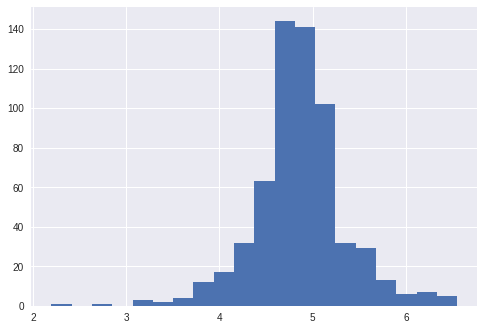

In [73]:
df['LoanAmount_log'] = np.log(df['LoanAmount'])
df['LoanAmount_log'].hist(bins=20)

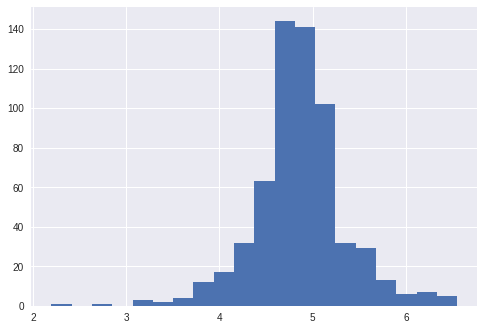

In [74]:
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['TotalIncome_log'] = np.log(df['TotalIncome'])
df['LoanAmount_log'].hist(bins=20) 

In [67]:
from sklearn.preprocessing import LabelEncoder

var_mod = ['Gender','Married','Dependents','Education','Self_Employed','Property_Area','Loan_Status']
le = LabelEncoder()

for i in var_mod:
  df[i] = le.fit_transform(df[i])

df.dtypes

Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term      object
Credit_History        object
Property_Area          int64
Loan_Status            int64
dtype: object

In [0]:
#Import models from scikit learn module:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold   #For K-fold cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

#Generic function for making a classification model and accessing performance:
def classification_model(model, data, predictors, outcome):
  #Fit the model:
  model.fit(data[predictors],data[outcome])
  
  #Make predictions on training set:
  predictions = model.predict(data[predictors])
  
  #Print accuracy
  accuracy = metrics.accuracy_score(predictions,data[outcome])
  print("Accuracy : %s" % "{0:.3%}".format(accuracy))

  #Perform k-fold cross-validation with 5 folds
  kf = KFold(data.shape[0], n_folds=5)
  error = []
  for train, test in kf:
    # Filter training data
    train_predictors = (data[predictors].iloc[train,:])
    
    # The target we're using to train the algorithm.
    train_target = data[outcome].iloc[train]
    
    # Training the algorithm using the predictors and target.
    model.fit(train_predictors, train_target)
    
    #Record error from each cross-validation run
    error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
 
  print("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))

  #Fit the model again so that it can be refered outside the function:
  model.fit(data[predictors],data[outcome]) 

In [69]:
outcome_var = 'Loan_Status'
model = LogisticRegression()
predictor_var = ['Credit_History']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 77.036%
Cross-Validation Score : 77.041%


In [70]:
predictor_var = ['Credit_History','Education','Married','Self_Employed','Property_Area']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 77.036%
Cross-Validation Score : 77.041%


In [71]:
model = DecisionTreeClassifier()
predictor_var = ['Credit_History','Gender','Married','Education']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 77.036%
Cross-Validation Score : 76.716%


In [75]:
#We can try different combination of variables:
predictor_var = ['Credit_History','Loan_Amount_Term','LoanAmount_log']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 88.762%
Cross-Validation Score : 63.351%


In [76]:
model = RandomForestClassifier(n_estimators=100)
predictor_var = ['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area',
        'LoanAmount_log','TotalIncome_log']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 100.000%
Cross-Validation Score : 74.268%


In [77]:
#Create a series with feature importances:
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print(featimp)

TotalIncome_log     0.222392
Dependents          0.203107
LoanAmount_log      0.199921
Credit_History      0.177645
Property_Area       0.053292
Loan_Amount_Term    0.047039
Married             0.027487
Gender              0.023783
Education           0.022907
Self_Employed       0.022428
dtype: float64


In [78]:
model = RandomForestClassifier(n_estimators=25, min_samples_split=25, max_depth=7, max_features=1)
predictor_var = ['TotalIncome_log','LoanAmount_log','Credit_History','Dependents','Property_Area']
classification_model(model, df,predictor_var,outcome_var)

Accuracy : 79.805%
Cross-Validation Score : 76.711%
